In [1]:
import javalang
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, Dense, GlobalMaxPooling1D, Input, Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

2025-06-03 14:36:44.646818: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 14:36:44.663363: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 14:36:44.783073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 14:36:44.888936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748983004.972671    2790 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748983004.99

In [2]:
dataset = pd.read_csv("../dataset/dataset_v2.csv")

def tokenize_and_normalize(source_code):
    tokens = list(javalang.tokenizer.tokenize(source_code))
    normalized_tokens = []
    for token in tokens:
        if isinstance(token, javalang.tokenizer.Identifier):
            normalized_tokens.append("IDENT")
        elif isinstance(token, javalang.tokenizer.String):
            normalized_tokens.append("STRING")
        elif isinstance(token, javalang.tokenizer.Integer):
            normalized_tokens.append("INT")
        elif isinstance(token, javalang.tokenizer.FloatingPoint):
            normalized_tokens.append("FLOAT")
        else:
            normalized_tokens.append(token.value)
    return normalized_tokens

all_tokens = []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    all_tokens.extend(tokenize_and_normalize(code1))
    all_tokens.extend(tokenize_and_normalize(code2))

encoder = LabelEncoder()
encoder.fit(list(set(all_tokens)))

LabelEncoder()

In [3]:
def tokens_to_sequence(tokens):
    return encoder.transform(tokens)

def preprocess_pair(code1, code2):
    tokens_1 = tokenize_and_normalize(code1)
    tokens_2 = tokenize_and_normalize(code2)
    seq_1 = tokens_to_sequence(tokens_1)
    seq_2 = tokens_to_sequence(tokens_2)
    return seq_1, seq_2

In [4]:
seq_1_list, seq_2_list, labels = [], [], []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    seq_1, seq_2 = preprocess_pair(code1, code2)
    seq_1_list.append(seq_1)
    seq_2_list.append(seq_2)
    labels.append(row.iloc[2])

max_len = max(max(len(s) for s in seq_1_list), max(len(s) for s in seq_2_list))
seq_1_list = pad_sequences(seq_1_list, maxlen=max_len)
seq_2_list = pad_sequences(seq_2_list, maxlen=max_len)
labels = np.array(labels)

X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(
    seq_1_list, seq_2_list, labels, test_size=0.2, random_state=42
)

In [5]:
vocab_size = len(encoder.classes_)
embedding_dim = 512

def build_encoder():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu')
    ])
    return model

encoder_model = build_encoder()

input_1 = Input(shape=(max_len,))
input_2 = Input(shape=(max_len,))

encoded_1 = encoder_model(input_1)
encoded_2 = encoder_model(input_2)

merged = Concatenate()([encoded_1, encoded_2])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_1, input_2], outputs=output)
siamese_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

/home/printchard/workspace/tc3002b/Code-Plagiarism-Detection/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1748983015.207201    2790 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748983015.207538    2790 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/printchard/workspace/tc3002b/Code-Plagiarism-Detection/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type Glo

In [6]:
# Train model
history = siamese_model.fit(
    [X_train_1, X_train_2], y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.5908 - loss: 0.6575 - val_accuracy: 0.8027 - val_loss: 0.4183
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.8719 - loss: 0.3514 - val_accuracy: 0.8834 - val_loss: 0.3463
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.9200 - loss: 0.2426 - val_accuracy: 0.8744 - val_loss: 0.3059
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.9311 - loss: 0.2230 - val_accuracy: 0.9058 - val_loss: 0.2956
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9268 - loss: 0.2177 - val_accuracy: 0.8969 - val_loss: 0.2998
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.9439 - loss: 0.2163 - val_accuracy: 0.9148 - val_loss: 0.2892
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.9462 - loss: 0.1715 - val_accuracy: 0.9103 - val_loss: 0.2983
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.9483 - loss: 0.1672 - val_accu

In [ ]:
test_similarity = siamese_model.predict([X_test_1, X_test_2])

threshold = 0.5
pred_labels = (test_similarity.flatten() > threshold).astype(int)
accuracy = np.mean(pred_labels == y_test)
print(f"Test set accuracy (threshold={threshold}): {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Test set accuracy (threshold=0.5): 0.9029


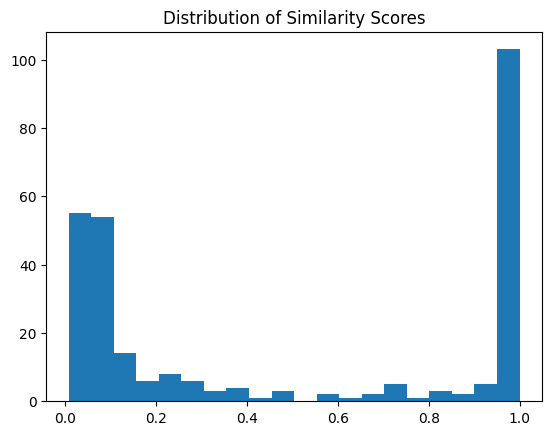

In [8]:
plt.hist(test_similarity.flatten(), bins=20)
plt.title("Distribution of Similarity Scores")
plt.show()

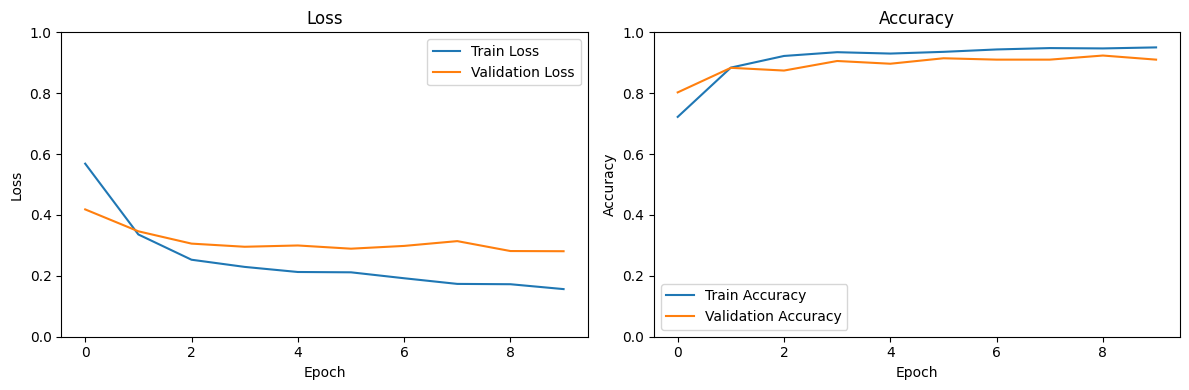

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_ylim((0, 1))
ax1.set_title('Loss')

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_ylim((0, 1))
ax2.set_title('Accuracy')

plt.tight_layout()
plt.show()

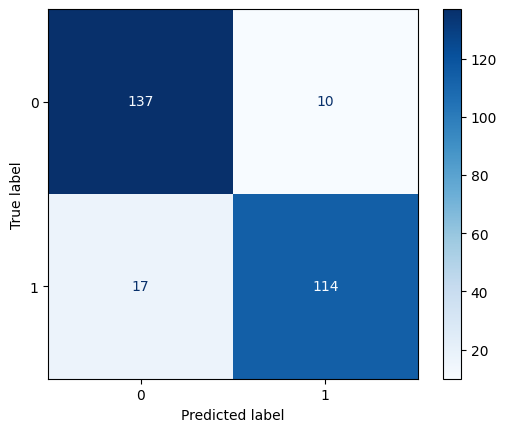

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [17]:
from sklearn.metrics import f1_score, recall_score, precision_score

recall = recall_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Recall: 0.8702
Precision: 0.9194
F1 Score: 0.8941


In [11]:
siamese_model.save_weights("siamese_model.weights.h5")